## LSTM Implementation

In [13]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('../data/AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2012,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,04-01-2012,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,05-01-2012,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,06-01-2012,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,09-01-2012,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...,...
2006,23-12-2019,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,24-12-2019,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,26-12-2019,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,27-12-2019,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


### Data Preprocessing

In [15]:
# Converting Date Column to DateTime Format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [16]:
# Setting Datetime as Index
dt = df.set_index('Date').rename_axis(None)
dt

,Open,High,Low,Close,Adj Close,Volume
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100
...,...,...,...,...,...,...
2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500


In [17]:
data = dt['Close'].values.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler

# Using MixMaxScaler to scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

### Model Building

In [18]:
# Function to create dataset with look_back
import numpy as np

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i: (i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])

    return np.array(X), np.array(Y)

In [23]:
# Setting the look_back period
look_back = 60

# Creating Dataset
train_size = int(len(scaled_data) * 0.80) # 80% split

train, test = scaled_data[:train_size], scaled_data[train_size:] # train is 80% and test is 20%

trainX, trainY = create_dataset(train, look_back)

testX, testY = create_dataset(test, look_back)

# Reshaping input to be [samples, time steps, feature]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [24]:
# Building LSTM Model
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(trainX, trainY, batch_size=1, epochs=2)

Epoch 1/2
1547/1547 [==============================] - 17s 10ms/step - loss: 8.3828e-04
Epoch 2/2
1547/1547 [==============================] - 15s 10ms/step - loss: 2.6593e-04


In [25]:
# Making Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculating root mean squared error
trainScore = np.sqrt(np.mean(
    (trainPredict[:,0] - trainY[0]) ** 2
))

testScore = np.sqrt(np.mean(
    (testPredict[:, 0] - testY[0])**2
))

print(f'Train Score: {trainScore} RMSE')
print(f'Test Score: {testScore} RMSE')

11/11 [==============================] - 0s 4ms/step
Train Score: 2.8820916508169048 RMSE
Test Score: 6.075501038074105 RMSE


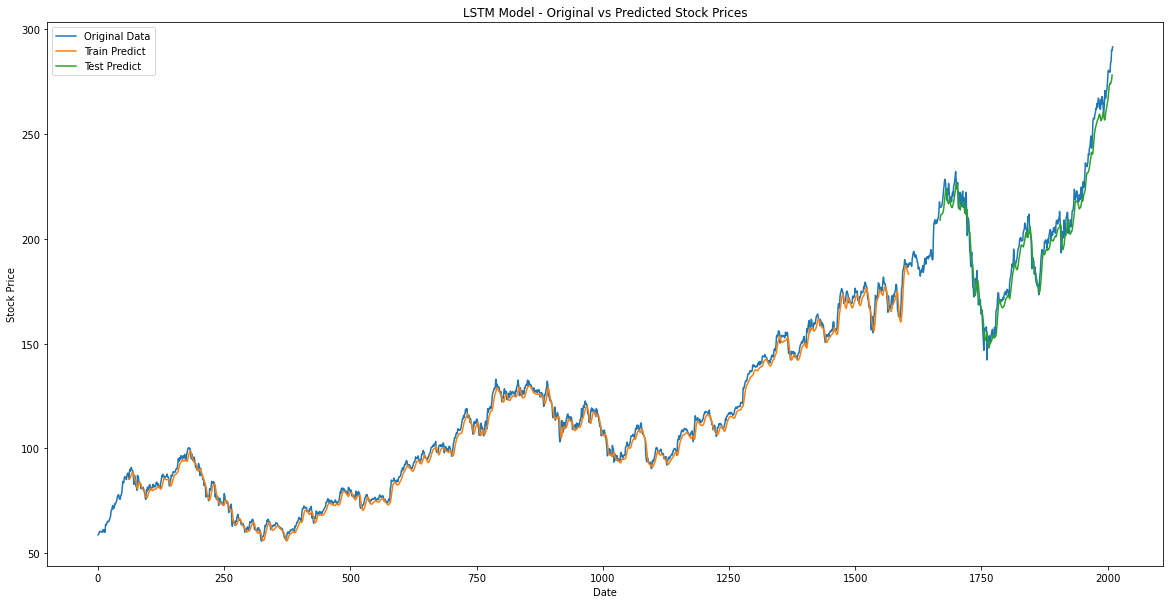

In [26]:
# Restructing shape of the array for plotting
import matplotlib.pyplot as plt

# Shifting train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shifting test predicitons for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) + 1 : len(scaled_data) - 1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM Model - Original vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### Making Forecasts

In [27]:
# Define function to forecast next n days
def forecast_next_days(model, data, n_days, look_back):
    forecast = []
    last_sequence = data[-look_back:]
    current_sequence = np.reshape(last_sequence, (1, look_back, 1))

    for _ in range(n_days):
        next_value = model.predict(current_sequence)
        forecast.append(next_value[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)

    return np.array(forecast)

1/1 [==============================] - 0s 20ms/step


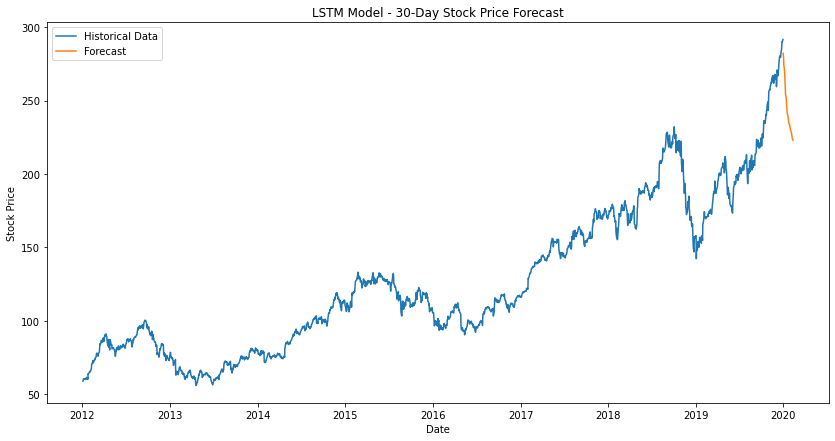

In [28]:
# Number of days to forecast
n_days = 30

# Getting the last look_back days from the dataset
last_sequence = scaled_data[-look_back:]

# Forecasting next 30 days
forecasted_values = forecast_next_days(model, scaled_data, n_days, look_back)

# Invertint the scaled predictions back to the original scale
forecasted_values = scaler.inverse_transform(forecasted_values.reshape(-1,1))

# Creating a Dataframe for plotting
forecast_dates = pd.date_range(
    start=dt.index[-1] + pd.Timedelta(days=1),
    periods=n_days,
    freq='B'
)

forecast_df = pd.DataFrame(
    forecasted_values,
    index=forecast_dates,
    columns=['Forecast']
)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(dt['Close'], label='Historical Data')
plt.plot(forecast_df, label='Forecast')
plt.title('LSTM Model - 30-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Hyperparameter Tuning

In [29]:
# Creating a Function to create the LSTM model

def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dense(25, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [30]:
# Wraping the model using the function
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=create_model, verbose=0)

# Defining the hyperparameters grid to search
param_grid={
    'units': [50, 100, 150],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [1, 32, 64],
    'epochs': [10, 20, 30]
}

In [31]:
# Splitting data to Train and Test

# Setting the look_back period
look_back = 60

# Creating Dataset
train_size = int(len(scaled_data) * 0.80) # 80% split

train, test = scaled_data[:train_size], scaled_data[train_size:] # train is 80% and test is 20%

trainX, trainY = create_dataset(train, look_back)

testX, testY = create_dataset(test, look_back)

# Reshaping input to be [samples, time steps, feature]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [32]:
# Creating the Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2
)

# Fitting the random search model
random_search_result = random_search.fit(trainX, trainY)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END activation=relu, batch_size=32, epochs=20, optimizer=adam, units=50; total time=  11.0s
[CV] END activation=relu, batch_size=32, epochs=20, optimizer=adam, units=50; total time=  10.8s
[CV] END activation=relu, batch_size=32, epochs=20, optimizer=adam, units=50; total time=  10.8s
[CV] END activation=relu, batch_size=32, epochs=10, optimizer=adam, units=50; total time=   7.4s
[CV] END activation=relu, batch_size=32, epochs=10, optimizer=adam, units=50; total time=   7.4s
[CV] END activation=relu, batch_size=32, epochs=10, optimizer=adam, units=50; total time=   7.0s
[CV] END activation=tanh, batch_size=64, epochs=10, optimizer=rmsprop, units=150; total time=   6.6s
[CV] END activation=tanh, batch_size=64, epochs=10, optimizer=rmsprop, units=150; total time=   6.5s
[CV] END activation=tanh, batch_size=64, epochs=10, optimizer=rmsprop, units=150; total time=   6.5s
[CV] END activation=relu, batch_size=32, epochs=30, op

In [33]:
# Printing the best parameters and score
print(f'Best Parameters: {random_search_result.best_params_}')
print(f'Best Score: {random_search_result.best_score_}')

Best Parameters: {'units': 50, 'optimizer': 'rmsprop', 'epochs': 30, 'batch_size': 32, 'activation': 'tanh'}
Best Score: -0.00017291224382158057


#### Building Model based on best parameters

In [34]:
best_model = Sequential()
best_model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
best_model.add(LSTM(units=50, return_sequences=False))
best_model.add(Dense(25, activation='tanh'))
best_model.add(Dense(1))
best_model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
best_model.fit(trainX, trainY, batch_size=1, epochs=30)

Epoch 1/30
1547/1547 [==============================] - 17s 9ms/step - loss: 0.0011
Epoch 2/30
1547/1547 [==============================] - 15s 9ms/step - loss: 3.0744e-04
Epoch 3/30
1547/1547 [==============================] - 14s 9ms/step - loss: 2.6090e-04
Epoch 4/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.8970e-04
Epoch 5/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.7083e-04
Epoch 6/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.4108e-04
Epoch 7/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.5066e-04
Epoch 8/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.1536e-04
Epoch 9/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.1658e-04
Epoch 10/30
1547/1547 [==============================] - 15s 9ms/step - loss: 1.2922e-04
Epoch 11/30
1547/1547 [==============================] - 14s 9ms/step - loss: 1.1386e-04
Epoch 12/30
1547/1547 [===========

#### Making Forecasts

In [35]:
# Splitting data to Train and Test

# Setting the look_back period
look_back = 60

# Creating Dataset
train_size = int(len(scaled_data) * 0.80) # 80% split

train, test = scaled_data[:train_size], scaled_data[train_size:] # train is 80% and test is 20%

trainX, trainY = create_dataset(train, look_back)

testX, testY = create_dataset(test, look_back)

# Reshaping input to be [samples, time steps, feature]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [36]:
# Making Predictions
trainPredict = best_model.predict(trainX)
testPredict = best_model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculating root mean squared error
trainScore = np.sqrt(np.mean(
    (trainPredict[:,0] - trainY[0]) ** 2
))

testScore = np.sqrt(np.mean(
    (testPredict[:, 0] - testY[0])**2
))

print(f'Train Score: {trainScore} RMSE')
print(f'Test Score: {testScore} RMSE')

11/11 [==============================] - 0s 5ms/step
Train Score: 2.535381836195348 RMSE
Test Score: 7.212944458103703 RMSE


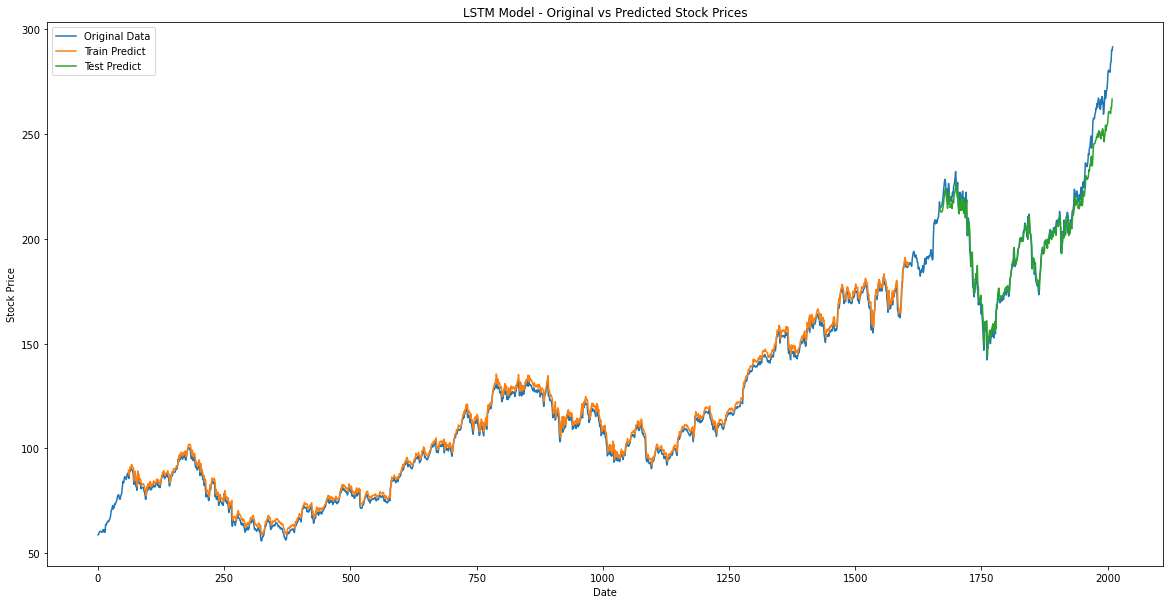

In [37]:
# Restructing shape of the array for plotting

# Shifting train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shifting test predicitons for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) + 1 : len(scaled_data) - 1, :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('LSTM Model - Original vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


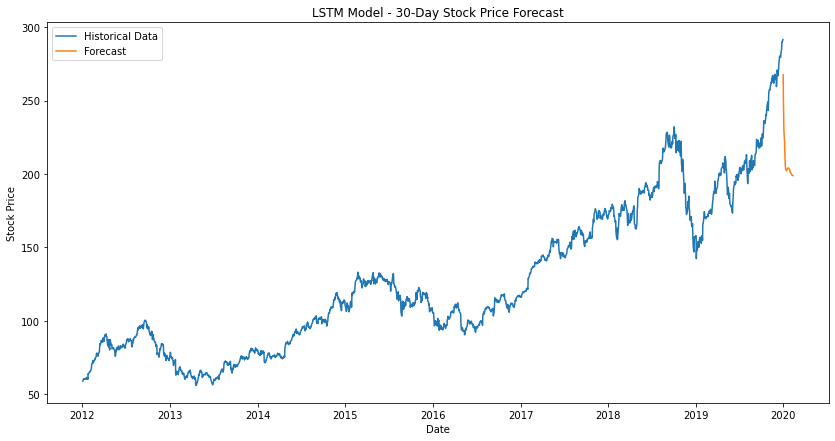

In [38]:
# Number of days to forecast
n_days = 30

# Getting the last look_back days from the dataset
last_sequence = scaled_data[-look_back:]

# Forecasting next 30 days
forecasted_values = forecast_next_days(best_model, scaled_data, n_days, look_back)

# Invertint the scaled predictions back to the original scale
forecasted_values = scaler.inverse_transform(forecasted_values.reshape(-1,1))

# Creating a Dataframe for plotting
forecast_dates = pd.date_range(
    start=dt.index[-1] + pd.Timedelta(days=1),
    periods=n_days,
    freq='B'
)

forecast_df = pd.DataFrame(
    forecasted_values,
    index=forecast_dates,
    columns=['Forecast']
)

# Plotting the results
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(dt['Close'], label='Historical Data')
plt.plot(forecast_df, label='Forecast')
plt.title('LSTM Model - 30-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()